In [1]:
from __future__ import division, absolute_import, print_function
%matplotlib inline

In [2]:
import time
import numpy as np

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [4]:
!echo $CUDA_VISIBLE_DEVICES

0


## Get the data

This is the data from the MADELON dataset http://archive.ics.uci.edu/ml/datasets/madelon

In [5]:
!ls dataset/MADELON

madelon.param	   madelon_train.data	 madelon_valid.data
madelon_test.data  madelon_train.labels


In [6]:
data = np.loadtxt("dataset/MADELON/madelon_train.data", dtype=np.int32)
validation_data = np.loadtxt("dataset/MADELON/madelon_valid.data", dtype=np.int32)
print(data.shape)
print(validation_data.shape)

(2000, 500)
(600, 500)


### Subset the data to exclude irrelevant features

In [7]:
#relevant_features = np.array([339,443,473,49,379,476,242,106,319,29,452,434,129,282,454,154,337,65,494])
#relevant_features = np.array([ 29, 49, 65, 106, 129, 154, 242, 282, 319, 337, 339, 379, 434, 443, 452, 454, 456, 473, 476, 494])
#relevant_features = np.array([18, 29, 45, 49, 65, 78, 80, 106, 122, 129, 136, 148, 154, 155, 189, 242, 254, 282, 302, 315, 319, 323, 337, 339, 366, 367, 379, 402, 403, 428, 434, 438, 443, 452, 454, 456, 470, 473, 476, 494])
all_models = np.load("TenMadelonModels.npy")
features_list = all_models[9].tolist()
relevant_features = np.array(all_models[9])
relevant_features = relevant_features - 1 # Convert 1 indexed to 0 indexed
data = data[:, relevant_features]
validation_data = validation_data[:, relevant_features]
print(data.shape)
print(validation_data)

(2000, 40)
[[454 490 510 ..., 454 538 259]
 [483 491 490 ..., 439 429 534]
 [457 479 474 ..., 494 517 495]
 ..., 
 [474 504 505 ..., 417 514 368]
 [461 468 490 ..., 501 521 638]
 [513 491 496 ..., 489 398 694]]


In [8]:
labels = np.loadtxt("dataset/MADELON/madelon_train.labels", dtype=np.int32)
validation_labels= np.loadtxt("dataset/madelon_valid.labels", dtype=np.int32)
print(labels.shape)
print(labels)

(2000,)
[-1 -1 -1 ..., -1  1  1]


### Normalize the data by getting using average and stdev

In [9]:
def get_average_and_stdev(input_array):
    avg = np.average(input_array, axis=0)
    return avg, np.std(input_array, axis=0)

In [10]:
def normalize(input_array, avg, stdev):
    avgremoved = input_array - avg[None,:]
    return avgremoved/stdev

#### Note that validation data is normalized using original bias and stdev

In [11]:
avg, stdev = get_average_and_stdev(data)
normalized = normalize(data, avg, stdev)
normalized_validation = normalize(validation_data, avg, stdev)
validation_pos_indices = np.nonzero(validation_labels == 1)[0]
normalized_validation_pos=normalize(validation_data[validation_pos_indices], avg, stdev)
print(avg.shape)
print(normalized.shape)
print(normalized_validation.shape)

(40,)
(2000, 40)
(600, 40)


In [12]:
background_indices = np.nonzero(labels == -1)[0]
#print(background_indices.shape)
#print(background_indices)
mean_bg_feature_values = np.average(normalized[background_indices], axis=0)
print(mean_bg_feature_values)
#print(mean_bg_feature_values.shape)

[-0.03609533 -0.00357137 -0.00671681 -0.11847695 -0.0338104   0.15032661
  0.00036677 -0.01377585 -0.12626289 -0.12675752 -0.00861636  0.03378346
 -0.04081777  0.00088387 -0.01811258 -0.03407828  0.03015419 -0.21782664
  0.03331272  0.03363522 -0.0126518   0.04952507 -0.00469233  0.01596474
  0.15167207  0.12178815 -0.00886381 -0.11596197  0.04598214  0.02981902
  0.02276057  0.11435599  0.0141396  -0.01160078  0.0955404   0.0064516
  0.02386877  0.11207091 -0.21993314  0.09505615]


In [13]:
print(np.std(normalized, axis=0))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]


In [14]:
from sklearn.externals import joblib
classifier = joblib.load('GaussianClassifier_Model10_Madelon_20Best_20Random_C1_G0_1.pkl')

In [15]:
import ssvmimp.imp_scores_helper
reload(ssvmimp.imp_scores_helper)
from ssvmimp.imp_scores_helper import ImportanceScoresHelper
impscoreshelper = ImportanceScoresHelper(
    classifier, 0.1,
    normalized, 
    labels, use_csr=False)

start = time.time()
impscores_bgref, avggrad_bgref =\
    impscoreshelper.get_feature_contribs_using_average_gradient_from_reference(
                normalized_validation,
                reference_to_use=np.array([mean_bg_feature_values for x in
                                            range(normalized_validation.shape[0])]),
                numsteps=100)
print("Importance scores computed in:", round(time.time() - start, 2), "s")
print(impscores_bgref)
print(avggrad_bgref.shape)
#final_importance_scores = np.sum(np.abs(impscores_bgref), axis=0)
final_importance_scores = np.sum(impscores_bgref, axis=0)
print(final_importance_scores)

Support vector shape is (1963, 40)
CSR support vector count is 78520
Starting average gradient calculation for  100 th point
Starting average gradient calculation for  200 th point
Starting average gradient calculation for  300 th point
Starting average gradient calculation for  400 th point
Starting average gradient calculation for  500 th point
Starting average gradient calculation for  600 th point
Avg grad computed in: 26.51 s
Importance scores computed in: 26.51 s
[[-0.05342126  0.09223222 -0.01840758 ...,  0.05262543  0.07715322
   0.03395834]
 [-0.00718104 -0.13273996 -0.00640014 ...,  0.1837934  -0.24398778
  -0.04967013]
 [-0.20060454 -0.01134374  0.00932398 ..., -0.01729659  0.1198422
   0.0116429 ]
 ..., 
 [-0.04831039 -0.0044082  -0.00642783 ...,  0.2645214   0.21235967
   0.24703232]
 [-0.24777831  0.13475768 -0.01058202 ..., -0.07030639  0.24008361
  -0.06726703]
 [ 0.38952896 -0.11182333  0.01035361 ...,  0.00223768 -0.23070273
  -0.17701176]]
(600, 40)
[ 15.70396824  20

In [16]:
sorted_indices = np.argsort(final_importance_scores)
print(sorted_indices)

[35 34 39  7 23 10 21 16 12 26 36 32 18  5 24 13 15 14 19 11  2  4  9 30 29
 28 27  6  8  3 20 22  0 33  1 17 38 25 37 31]


In [17]:
important_features_ascending = np.array(features_list)[sorted_indices]
print(important_features_ascending)
top_10_feature_set = set(important_features_ascending[-10:].flat)
top_20_feature_set = set(important_features_ascending[-20:].flat)
print(top_10_feature_set)
print(top_20_feature_set)

[456 454 494 105 335 134 287 218 164 352 464 451 256  65 337 170 208 187
 282 154  30  54 129 442 434 426 379  98 106  49 285 319  27 452  29 242
 476 339 473 443]
set([443, 452, 285, 242, 339, 473, 27, 476, 29, 319])
set([129, 98, 27, 452, 443, 426, 29, 242, 285, 49, 434, 339, 54, 473, 442, 379, 476, 106, 30, 319])


In [18]:
original_feature_set = set(np.array([ 29, 49, 65, 106, 129, 154, 242, 282, 319, 337, 339, 379, 434, 443, 452, 454, 456, 473, 476, 494]).flat)
print("Number in top 10 ", len(top_10_feature_set) - len(top_10_feature_set - original_feature_set))
print("Number in top 20 ", len(top_20_feature_set) - len(top_20_feature_set - original_feature_set))

Number in top 10  8
Number in top 20  13


(array([ 8.,  7.,  1.,  9.,  9.,  1.,  0.,  1.,  2.,  2.]),
 array([ 26.12997243,  33.38094999,  40.63192755,  47.88290511,
         55.13388268,  62.38486024,  69.6358378 ,  76.88681537,
         84.13779293,  91.38877049,  98.63974805]),
 <a list of 10 Patch objects>)

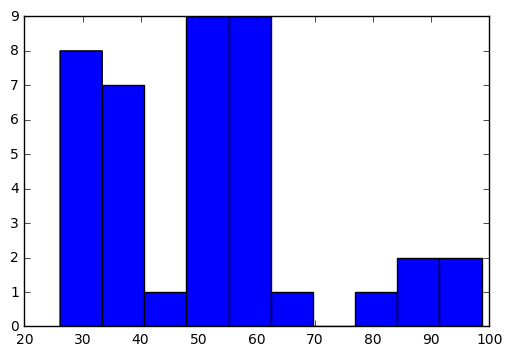

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(final_importance_scores)